In [2]:
# materials/stack

import pickle
import numpy as np
np.float_ = np.float64
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
import matplotlib.pyplot as plt

data = pd.read_parquet('data/raw/data_v1.parquet')

In [3]:
# Running MAUs model

# Função para carregar o modelo Prophet
def load_prophet_model(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Função para gerar previsões
def make_forecast(model, periods, frequency):
    future = model.make_future_dataframe(periods=periods, freq=frequency)
    return model.predict(future)

# Caminhos dos modelos
models = {
    'ig': 'models/ig_maus_prophet_model_v1',
    'tk': 'models/tk_maus_prophet_model_v1'
}

# Carregar modelos
ig_model = load_prophet_model(models['ig'])
tk_model = load_prophet_model(models['tk'])

# Fazer previsões
ig_maus_forecast = make_forecast(ig_model, periods=4, frequency='QE')
tk_maus_forecast = make_forecast(tk_model, periods=4, frequency='QE')

/workspaces/instagram-x-tiktok/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# modelagem reg linear
ig_y = np.array(data['ig_revenue'].values).reshape(-1, 1)
ig_X = np.array(data['ig_maus'].values).reshape(-1, 1) 

tk_y = np.array(data['tk_revenue'].values).reshape(-1, 1)
tk_X = np.array(data['tk_maus'].values).reshape(-1, 1)  

ig_new_X = np.array(ig_maus_forecast['yhat'].tail(4).values).reshape(-1, 1)
tk_new_X = np.array(tk_maus_forecast['yhat'].tail(4).values).reshape(-1, 1)

ig_model = LinearRegression().fit(ig_X, ig_y)
tk_model = LinearRegression().fit(tk_X, tk_y)

ig_y_pred = ig_model.predict(ig_new_X)
tk_y_pred = tk_model.predict(tk_new_X)

In [5]:
# Criação do DataFrame vazio
forecast = pd.DataFrame()

# Adicionando a coluna 'quarter' com os últimos 4 valores de 'ds' de ig_maus_forecast
forecast['quarter'] = ig_maus_forecast['ds'].tail(4)
forecast['quarter_label'] = ['Q2 2024', 'Q3 2024', 'Q4 2024', 'Q1 2025']

# ig
forecast['ig_maus'] = ig_new_X.round(0).astype(int)
forecast['ig_revenue'] = ig_y_pred.round(0).astype(int)

# tk
forecast['tk_maus'] = tk_new_X.round(0).astype(int)
forecast['tk_revenue'] = tk_y_pred.round(0).astype(int)

In [6]:
# original data and forecast
display(data.tail(4))
display(forecast)

,quarter,quarter_label,ig_maus,ig_revenue,tk_maus,tk_revenue
17,2023-04-01,Q2 2023,2115000000,11775000000,1587000000,3667000000
18,2023-07-01,Q3 2023,2145000000,12736000000,1616000000,4241000000
19,2023-10-01,Q4 2023,2180000000,15322000000,1635000000,4997000000
20,2024-01-01,Q1 2024,2231000000,14472000000,1666000000,4583000000


,quarter,quarter_label,ig_maus,ig_revenue,tk_maus,tk_revenue
21,2024-03-31,Q2 2024,2221735781,12735807893,1871336709,4527462823
22,2024-06-30,Q3 2024,2242448858,12929389484,1631989456,3749413402
23,2024-09-30,Q4 2024,2276922459,13251575055,1576689951,3569650540
24,2024-12-31,Q1 2025,2369122780,14113266663,1495697320,3306366674


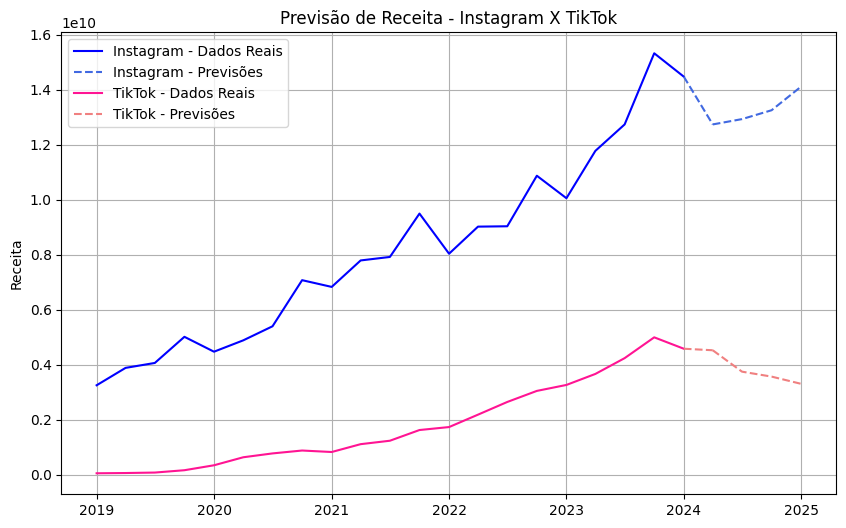

In [7]:
# graficos

# Definir o tamanho da figura
plt.figure(figsize=(10, 6))

# Plotar os dados reais de Instagram
plt.plot(data['quarter'], data['ig_revenue'], label='Instagram - Dados Reais', color='blue')

# Plotar as previsões de Instagram
plt.plot(forecast['quarter'], forecast['ig_revenue'], label='Instagram - Previsões', linestyle='--', color='#4169E1')

# Adicionar ponto de conexão entre os dados reais e as previsões de Instagram
plt.plot([data['quarter'].iloc[-1], forecast['quarter'].iloc[0]], 
         [data['ig_revenue'].iloc[-1], forecast['ig_revenue'].iloc[0]], 
         linestyle='--', color='#4169E1')

# Plotar os dados reais de TikTok
plt.plot(data['quarter'], data['tk_revenue'], label='TikTok - Dados Reais', color='#FF1493')

# Plotar as previsões de TikTok
plt.plot(forecast['quarter'], forecast['tk_revenue'], label='TikTok - Previsões', linestyle='--', color='#F08080')

# Adicionar ponto de conexão entre os dados reais e as previsões de TikTok
plt.plot([data['quarter'].iloc[-1], forecast['quarter'].iloc[0]], 
         [data['tk_revenue'].iloc[-1], forecast['tk_revenue'].iloc[0]], 
         linestyle='--', color='#F08080')

# Adicionar legendas e rótulos
plt.legend()
plt.ylabel('Receita')
plt.title('Previsão de Receita - Instagram X TikTok')
plt.grid(True)

# Mostrar o gráfico
plt.show()

In [9]:
# export forecast
forecast.to_parquet('data/processed/data_v1_forecast.parquet', index=False)

In [15]:
# Running revenue model

# Função para carregar o modelo Prophet
def load_prophet_model(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Função para gerar previsões
def make_forecast(model, periods, frequency):
    future = model.make_future_dataframe(periods=periods, freq=frequency)
    return model.predict(future)

# Caminhos dos modelos
r_models = {
    'ig': 'models/ig_revenue_prophet_model_v1',
    'tk': 'models/tk_revenue_prophet_model_v1'
}

# Carregar modelos
r_ig_model = load_prophet_model(r_models['ig'])
r_tk_model = load_prophet_model(r_models['tk'])

# Fazer previsões
ig_revenue_forecast = make_forecast(r_ig_model, periods=4, frequency='QE')
tk_revenue_forecast = make_forecast(r_tk_model, periods=4, frequency='QE')

ig_R = np.array(ig_revenue_forecast['yhat'].tail(4).values).reshape(-1, 1)
tk_R = np.array(tk_revenue_forecast['yhat'].tail(4).values).reshape(-1, 1)

In [22]:
# Criação do DataFrame vazio
forecast_v2 = pd.DataFrame()

# Adicionando a coluna 'quarter' com os últimos 4 valores de 'ds' de ig_maus_forecast_v2
forecast_v2['quarter'] = ig_maus_forecast['ds'].tail(4)
forecast_v2['quarter_label'] = ['Q2 2024', 'Q3 2024', 'Q4 2024', 'Q1 2025']

# ig
forecast_v2['ig_maus'] = ig_new_X.round(0).astype(int)
forecast_v2['ig_revenue'] = ig_R.round(0).astype(int)

# tk
forecast_v2['tk_maus'] = tk_new_X.round(0).astype(int)
forecast_v2['tk_revenue'] = tk_R.round(0).astype(int)

In [24]:
forecast

,quarter,quarter_label,ig_maus,ig_revenue,tk_maus,tk_revenue
21,2024-03-31,Q2 2024,2221735781,12735807893,1871336709,4527462823
22,2024-06-30,Q3 2024,2242448858,12929389484,1631989456,3749413402
23,2024-09-30,Q4 2024,2276922459,13251575055,1576689951,3569650540
24,2024-12-31,Q1 2025,2369122780,14113266663,1495697320,3306366674


In [25]:
forecast_v2

,quarter,quarter_label,ig_maus,ig_revenue,tk_maus,tk_revenue
21,2024-03-31,Q2 2024,2221735781,14151546233,1871336709,5749225737
22,2024-06-30,Q3 2024,2242448858,16765018261,1631989456,6435724221
23,2024-09-30,Q4 2024,2276922459,20488542184,1576689951,7636252641
24,2024-12-31,Q1 2025,2369122780,20241305024,1495697320,5986963414


In [26]:
# export forecast 2
forecast_v2.to_parquet('data/processed/data_v1_forecast_v2.parquet', index=False)